In [33]:
import numpy as np
import IPython
import scipy.io.wavfile
import scipy.signal as sig
import matplotlib.pyplot as plt

In [34]:
frate, file = scipy.io.wavfile.read("./data/array.wav")

# PART 1

### the formula of steering vector

In [35]:
def v( theta, m, k, fs):
    N = 1024
    R = fs
    C = 345
    r = 0.1
    return np.exp(-1j*(m-1)*r*np.cos(theta)*R*2*np.pi*k/(C*N))

### The triple loop that computes the steering vector output 

In [36]:
steering_vector = np.zeros((50,8,513), dtype=complex)
for i, theta in enumerate(np.linspace(0, np.pi, 51)):
    if (i < 50):
        for j in range(8):
            for k in range(513):
                steering_vector[i,j,k] = v(theta, j, k, frate)

# PART 2

### STFT code from Lab 1 

In [48]:
# STFT code from lab 1
from numpy.fft import rfft, irfft, fftfreq
def foward_transform(input_sound, dft_size, hop_size, zero_pad, window):
    input_len = len(input_sound)
    idx = 0
    segments = []
    while idx+dft_size < input_len:
        s = input_sound[idx:idx+dft_size]
        segments.append(np.multiply(s, window))
        idx += hop_size
    else:
        s = np.append(input_sound[idx:-1], np.zeros(idx+dft_size-input_len+1))
        segments.append(np.multiply(s, window))
    frames = np.array(segments)
    
    dft_frames = []
    for idx, x in enumerate(frames):
        dft_frames.append(rfft(x, dft_size + zero_pad))
    dft_frames = np.array(dft_frames, dtype=complex)
    return dft_frames 

def inverse_transform(input_sound, dft_size, hop_size, zero_pad, window):
    leng = hop_size*(len(input_sound)-1)+dft_size+zero_pad
    output = np.zeros(leng, dtype=complex)
    for idx, row in enumerate(input_sound):
        frame = np.multiply(irfft(row, dft_size + zero_pad), window)
        output[idx*hop_size:idx*hop_size+dft_size+zero_pad] += frame
    return output

def stft( input_sound, dft_size, hop_size, zero_pad, window):
    if input_sound.ndim == 1 and np.isreal(input_sound).all():
        return foward_transform(input_sound, dft_size, hop_size, zero_pad, window)
    else:
        return inverse_transform(input_sound, dft_size, hop_size, zero_pad, window)

### Compute the acoustic energies

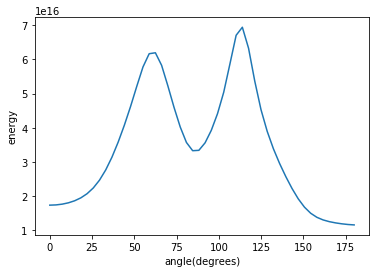

We can see that there are actually two peaks on this graph!
The first peak is around 60 degrees, and the second on is around 110


In [47]:
Hann_window = np.hanning(1024)
energies = []
for theta_idx in range(50):
    energy = np.zeros(513, complex)
    for ch_idx in range(8):
        channel = file.T[ch_idx]
        vector = steering_vector[theta_idx][ch_idx]
        res = stft(channel,1024, 256, 0, Hann_window)*np.conj(vector)
        energy = np.add(res, energy) 
    energies.append(np.real(np.sum(energy * np.conj(energy))))
energies = np.array(energies)
plt.plot(np.linspace(0, 180, 50), energies)
plt.xlabel("angle(degrees)")
plt.ylabel("energy")
plt.show()
print("We can see that there are actually two peaks on this graph!")
print("The first peak is around 60 degrees, and the second on is around 110")

# PART 3

### Find the angles of the peaks 

In [43]:
peaks, properties = sig.find_peaks(energies)
print("Now we have found the degrees of peaks as following:")
print(peaks*180/50)

Now we have found the degrees of peaks as following:
[ 61.2 111.6]


### Compute the Beamforming on those angles

In [46]:
output_stft = []
output = []
for theta_idx in peaks:
    energy = np.zeros(513, complex)
    for ch_idx in range(8):
        channel = file.T[ch_idx]
        vector = steering_vector[theta_idx][ch_idx]
        res = stft(channel,1024, 256, 0, Hann_window)*np.conj(vector)
        energy = np.add(res, energy) 
    output_stft.append(energy)
print("The first sound focus on the music, and the second sound focus on the speech!")
for i in output_stft:
    output = np.real(stft(i, 1024, 256, 0, Hann_window))
    IPython.display.display( IPython.display.Audio( output, rate=frate))
print("Now we can hear both part of the original sound more clearly!")

The first sound focus on the music, and the second sound focus on the speech!


Now we can hear both part of the original sound more clearly!
